# Stock Price Prediction — Amazon (AMZN)
## Notebook 1 — Data Collection & Exploratory Data Analysis (EDA)

### Objective
The purpose of this notebook is to:
1. Download and store historical Amazon (AMZN) daily market data.
2. Inspect data quality (missing values, types, date range).
3. Perform basic exploratory analysis (price evolution, returns distribution, volatility, volume).
4. Produce clean outputs that will be reused in the next notebooks (feature engineering and modeling).

### Why this matters
A machine learning model is only as good as the data pipeline behind it. Before creating features or training models, we must ensure:
- the dataset is reliable,
- the time range is correct,
- variables are clearly understood,
- and no data leakage is introduced later.

## 1. Data Source

We use historical daily stock data for **Amazon (ticker: AMZN)** obtained from **Yahoo Finance**.
The data is downloaded programmatically using the **Python `yfinance` library**, which provides:
- Open, High, Low, Close prices (OHLC),
- Adjusted Close (Adj Close),
- Trading Volume.

### Why “Adj Close”?
For long historical periods, the **Adjusted Close** is often preferred because it accounts for corporate actions (e.g., stock splits and dividends). This makes the time series more consistent over time and reduces distortions when analyzing long-term trends.
In this project, we will use **Adj Close as our main price reference**.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

## 2. Download Configuration

We download AMZN daily data from **2005-01-01 to 2024-12-31**.

### Why start in 2005?
Using a long time window helps the model observe different market regimes and major events:
- 2008 financial crisis,
- long bull market periods,
- COVID crash and recovery,
- recent inflation / rate regimes.

This improves robustness and reduces the risk of training only on one specific market phase.

In [96]:
df = yf.download("AMZN", start="2005-01-01", end="2025-01-01", auto_adjust=False)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,,
2005-01-03,2.2260,2.2260,2.2720,2.2105,2.2475,208930000
2005-01-04,2.1070,2.1070,2.1630,2.0750,2.1335,388370000
2005-01-05,2.0885,2.0885,2.1380,2.0780,2.0785,167084000
2005-01-06,2.0525,2.0525,2.1125,2.0450,2.0905,174018000
2005-01-07,2.1160,2.1160,2.1345,2.0580,2.0690,196732000


In [97]:
sp500 = yf.download("^GSPC", start="2005-01-01", end="2025-01-01", auto_adjust=False)
sp500.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2005-01-03,1202.079956,1202.079956,1217.800049,1200.319946,1211.920044,1510800000
2005-01-04,1188.050049,1188.050049,1205.839966,1185.390015,1202.079956,1721000000
2005-01-05,1183.739990,1183.739990,1192.729980,1183.719971,1188.050049,1738900000
2005-01-06,1187.890015,1187.890015,1191.630005,1183.270020,1183.739990,1569100000
2005-01-07,1186.189941,1186.189941,1192.199951,1182.160034,1187.890015,1477900000


## 3. Initial Data Inspection

We start by inspecting:
- dataset shape (number of rows, columns),
- date range and frequency,
- data types (float, int),
- missing values,
- and basic descriptive statistics.

This step ensures the dataset is consistent and ready for transformations (returns, features, target creation).

In [98]:
print("AMAZON DATAFRAMES:")

df.columns = df.columns.get_level_values(0)
df.info()
df.describe()
df.isna().sum()

print("\nS&P 500 DATAFRAMES:")
sp500.columns = sp500.columns.get_level_values(0)
sp500.info()
sp500.describe()
sp500.isna().sum()

AMAZON DATAFRAMES:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5033 entries, 2005-01-03 to 2024-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  5033 non-null   float64
 1   Close      5033 non-null   float64
 2   High       5033 non-null   float64
 3   Low        5033 non-null   float64
 4   Open       5033 non-null   float64
 5   Volume     5033 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 275.2 KB

S&P 500 DATAFRAMES:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5033 entries, 2005-01-03 to 2024-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  5033 non-null   float64
 1   Close      5033 non-null   float64
 2   High       5033 non-null   float64
 3   Low        5033 non-null   float64
 4   Open       5033 non-null   float64
 5   Volume     5033 non-null   int64  
dtypes: float64(5), 

Price
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

## 4. Understanding the Variables (OHLCV)

Each row corresponds to one trading day. The main variables are:

- **Open**: price at market open.
- **High**: highest traded price during the day.
- **Low**: lowest traded price during the day.
- **Close**: price at market close.
- **Adj Close**: close price adjusted for corporate actions (splits/dividends).
- **Volume**: number of shares traded during the day.

### How will we use them later?
- We will primarily use **Adj Close** to build lagged features and compute returns.
- OHLC can be used to create volatility or range features (e.g., High–Low).
- Volume can capture information about market activity and momentum.

In [99]:
# We create a new column called `Price` equal to `Adj Close` to simplify later analysis and modeling.  
# Using a shorter and clearer name makes the code easier to read and avoids repeatedly referencing the longer column name.

df["Price"] = df["Adj Close"]
sp500["Price"] = sp500["Adj Close"]

## 5. Price Evolution (AMZN)

We visualize the Adjusted Close price over time to:
- verify the time range visually,
- observe global trends and structural changes,
- detect abnormal spikes or data issues.

This plot also provides a baseline understanding of how challenging the prediction task is:
stock prices are typically **non-stationary** and influenced by many external factors.

<Axes: title={'center': 'AMZN Adjusted Close (2005–2024)'}, xlabel='Date', ylabel='Price ($)'>

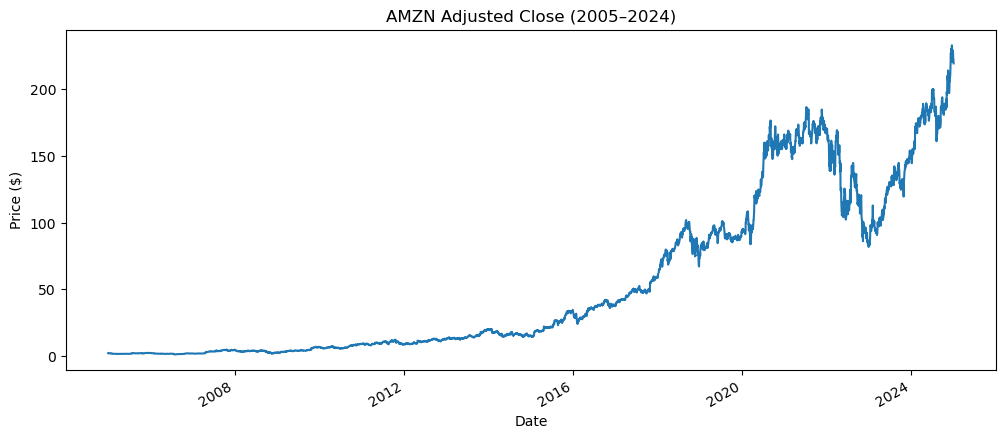

In [100]:
df["Price"].plot(figsize=(12,5), title="AMZN Adjusted Close (2005–2024)", ylabel="Price ($)", xlabel="Date")

The AMZN price series shows a strong long-term upward trend with several periods of rapid growth and market corrections.

This confirms that the stock price is non-stationary, meaning its statistical properties change over time. Such behavior makes prediction more challenging and justifies the need for machine learning models capable of capturing temporal patterns.

The presence of different market regimes (growth periods, crashes, recoveries) also highlights the importance of using a long historical window to improve model robustness.

<Axes: title={'center': 'SP500 Adjusted Close (2005–2024)'}, xlabel='Date', ylabel='Price ($)'>

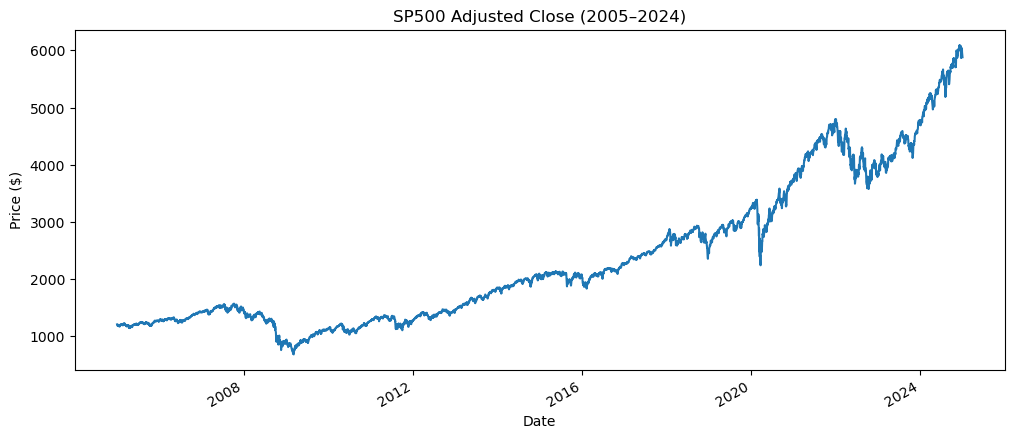

In [101]:
sp500["Price"].plot(figsize=(12,5), title="SP500 Adjusted Close (2005–2024)", ylabel="Price ($)", xlabel="Date")

## 6. Daily Returns

To better analyze price movements, we compute **daily returns**:

*Return_t = (Price_t - Price_{t-1}) / Price_{t-1}*

Returns are useful because:
- they represent *relative* change instead of raw price,
- they are often closer to stationary than price levels,
- they help quantify volatility and extreme movements.

Even if our final target is the price, returns are essential for understanding the dataset and market dynamics.

In [102]:
df["Return"] = df["Price"].pct_change()
sp500["Return"] = sp500["Price"].pct_change()

In [103]:
print("\nAMAZON PRICE AND RETURN:")
df[["Price","Return"]].head()

print("\nS&P 500 PRICE AND RETURN:")
sp500[["Price","Return"]].head()


AMAZON PRICE AND RETURN:

S&P 500 PRICE AND RETURN:


Price,Price,Return
Date,,
2005-01-03,1202.079956,NaN
2005-01-04,1188.050049,-0.011671
2005-01-05,1183.739990,-0.003628
2005-01-06,1187.890015,0.003506
2005-01-07,1186.189941,-0.001431


In [104]:
df = df.dropna()
sp500 = sp500.dropna()

## 7a. Returns Distribution

We inspect the distribution of daily returns:
- to see typical daily movement magnitude,
- to detect heavy tails (extreme events),
- to understand whether the data is symmetric or skewed.

This is important because stock returns often deviate from a normal distribution, which can affect model assumptions and evaluation.

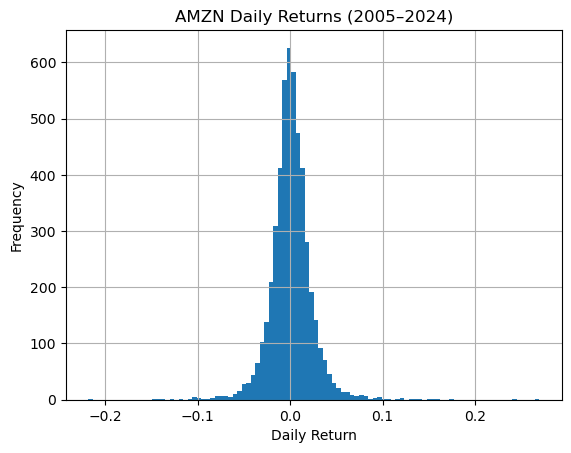

In [105]:
df["Return"].hist(bins=100)

plt.title("AMZN Daily Returns (2005–2024)")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

plt.show()

The distribution of daily returns is centered around zero, indicating that most daily price changes are relatively small.

The histogram shows a roughly bell-shaped structure, suggesting that returns fluctuate around a stable mean. However, the presence of extreme values in both directions indicates heavy tails, meaning that large market movements occasionally occur.

This behavior is typical for financial time series and highlights the importance of using models that are robust to volatility and sudden shocks.

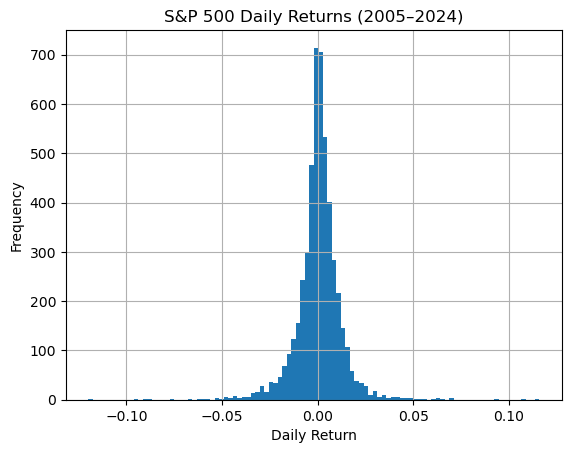

In [106]:
sp500["Return"].hist(bins=100)

plt.title("S&P 500 Daily Returns (2005–2024)")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

plt.show()

## 7b. Feature Correlation Analysis

We inspect correlations between the main variables (Price, Return, Volume)
to better understand their relationships.

This helps identify:

- whether variables contain redundant information,
- whether volume is related to price movements,
- and whether any obvious predictive signals exist.

This step is exploratory and does not imply causality.

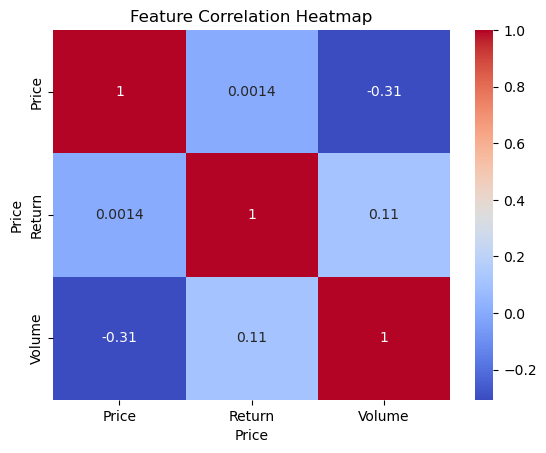

In [107]:
sns.heatmap(
    df[["Price","Return","Volume"]].corr(),
    annot=True,
    cmap="coolwarm"
)

plt.title("Feature Correlation Heatmap")
plt.show()

The correlation heatmap shows that there is no strong linear relationship between Price, Return, and Volume.

Price and Return are almost uncorrelated, which is expected since daily returns depend on short-term fluctuations rather than absolute price levels.

Return and Volume show only a weak positive relationship, suggesting that trading activity alone does not strongly explain daily price movements.

Overall, the absence of strong correlations is typical in financial time series and highlights the difficulty of predicting stock prices using simple linear relationships.

## 8. Volatility Over Time (Rolling Standard Deviation)

We compute a rolling volatility measure using the standard deviation of returns over a moving window (e.g., 30 trading days).

This helps identify market regimes:
- calm periods (low volatility),
- crisis periods (high volatility spikes).

Understanding volatility is important because prediction errors tend to increase during turbulent market conditions.

<Axes: title={'center': '30-day rolling volatility'}, xlabel='Date', ylabel='Rolling Std Dev'>

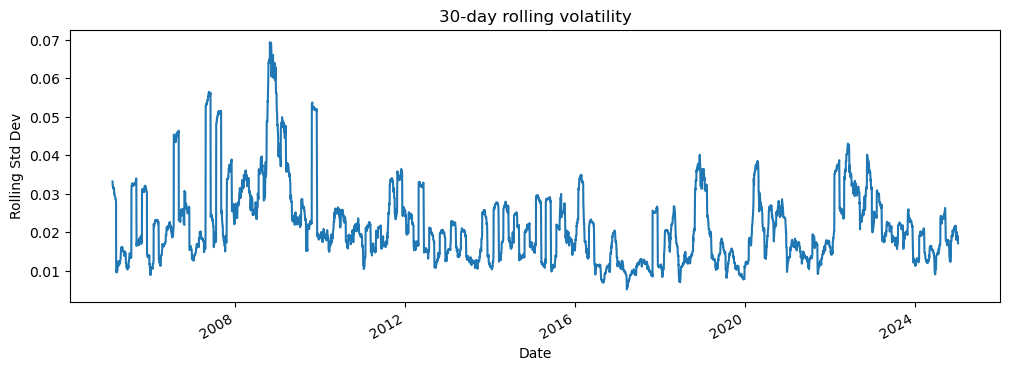

In [108]:
df["Return"].rolling(30).std().plot(figsize=(12,4), title="30-day rolling volatility", ylabel="Rolling Std Dev", xlabel="Date")

The rolling volatility plot shows how the variability of daily returns evolves over time.

Periods with low values correspond to relatively stable market conditions, while spikes indicate turbulent periods with larger price movements.

This confirms that stock market volatility is not constant over time and tends to increase during periods of financial stress or major events. Such fluctuations make prediction more challenging and highlight the importance of models that remain robust across different market regimes.

<Axes: title={'center': '30-day rolling volatility'}, xlabel='Date', ylabel='Rolling Std Dev'>

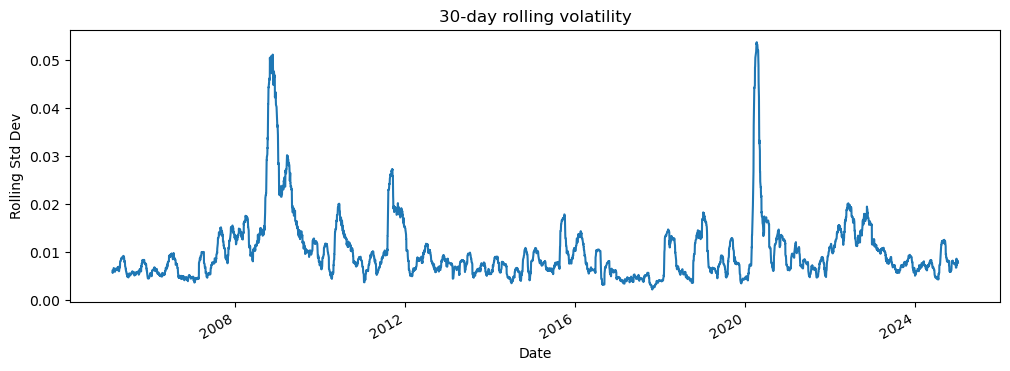

In [109]:
sp500["Return"].rolling(30).std().plot(figsize=(12,4), title="30-day rolling volatility", ylabel="Rolling Std Dev", xlabel="Date")

## 9. Volume Analysis

We analyze trading volume because:
- volume spikes can reflect major news or events,
- volume can be a proxy for market interest and liquidity,
- it may help the model capture periods of high activity.

We will later consider adding lagged or rolling volume features.

<Axes: title={'center': 'AMZN Trading Volume'}, xlabel='Date', ylabel='Volume'>

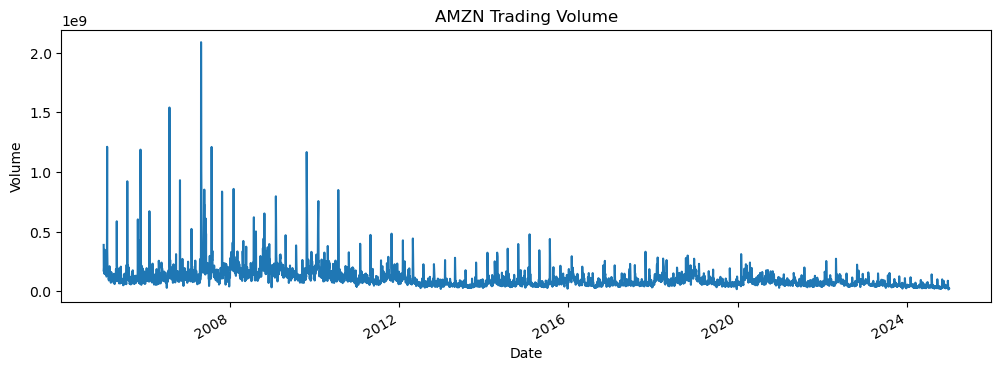

In [110]:
df["Volume"].plot(figsize=(12,4), title="AMZN Trading Volume", ylabel="Volume", xlabel="Date")

The trading volume plot shows strong variability over time, with several sharp spikes corresponding to periods of intense market activity.

Such spikes often coincide with major news, earnings announcements, or market-wide events. While volume appears noisy and highly variable, it may still contain useful information about market interest and liquidity.

These observations suggest that volume-based features (such as lagged volume or rolling averages) could be useful inputs for the predictive model.

## 10. Output Saving

At the end of this notebook, we save:
- the raw dataset (cleaned column format),
- and a version with basic engineered columns (e.g., Price, Return).

These outputs will be reused in:
- Notebook 2: feature engineering and target creation,
- Notebook 3: model training,
- Notebook 4: evaluation and visualization.

In [111]:
df["SP500"] = sp500["Adj Close"].reindex(df.index)
df["SP500_Return"] = df["SP500"].pct_change()
df = df.dropna()

In [112]:
df.to_csv("../data/raw/amzn_sp500_clean.csv")

### Note on Data Leakage
At this stage, we only compute descriptive transformations (returns, rolling statistics for visualization).
We do **not** create the prediction target or train models yet.
All future train/test splits will be chronological to respect the time-series nature of the data.

## Conclusion

In this notebook, we collected and explored historical daily stock data for Amazon (AMZN). The dataset was verified to be clean, complete, and properly structured for time-series analysis.

The exploratory analysis revealed several important characteristics of financial data. The stock price shows a strong long-term upward trend and clear non-stationary behavior, meaning its statistical properties change over time. Daily returns are centered around zero but exhibit heavy tails, indicating occasional large market movements. Rolling volatility analysis confirmed that market turbulence varies across different periods, with spikes corresponding to stressful market conditions. Trading volume was found to be highly variable, with spikes reflecting periods of increased market activity.

Overall, this analysis confirms that stock price prediction is a challenging task due to noise, non-stationarity, and changing market regimes. The cleaned dataset and initial exploratory features (Price, Return, Volume) will serve as the foundation for feature engineering and model training in the next notebooks.

**Next step: Feature Engineering and Target Creation (Notebook 2).**